In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

In [3]:
df_char_vis = pd.read_csv(
    'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-06-30/character_visualization.csv'
)

In [4]:
df_best_chars = pd.DataFrame({
    "rank": np.linspace(1, 10, num=10),
    "char_popular": ["Wolverine", "Magneto", "Nightcrawler", "Gambit",
                     "Storm", "Colossus", "Phoenix", "Professor X", 
                     "Iceman", "Rogue"]
})

In [5]:
# When 'character' contains one of 'char_popular',replace it with 'chacarter'
# so it is possible to merge 'df_char_vis' and 'df_best_chars'
for char in df_best_chars["char_popular"]:
    idxs = df_char_vis["character"].str.contains(char)
    df_char_vis.loc[idxs, "character_join"] = char

In [6]:
## top 5 most popular X-Men characters
## source: https://www.ranker.com/list/best-x-men-characters/ranker-comics
df_best_stream = (
    pd.merge(df_char_vis, df_best_chars, left_on="character_join", right_on="char_popular")
    .groupby(["character", "char_popular", "costume", "rank", "issue"]).agg(
        speech = ("speech", sum),
        thought = ("thought", sum),
        narrative = ("narrative", sum),
        depicted = ("depicted", sum),
    )
    .query("rank <= 5")
    .query("issue < 281")
    .reset_index()
)
df_best_stream

,character,char_popular,costume,rank,issue,speech,thought,narrative,depicted
0,Gambit = Name Unknown,Gambit,Costume,4.0,97,0,0,0,0
1,Gambit = Name Unknown,Gambit,Costume,4.0,98,0,0,0,0
2,Gambit = Name Unknown,Gambit,Costume,4.0,99,0,0,0,0
3,Gambit = Name Unknown,Gambit,Costume,4.0,100,0,0,0,0
4,Gambit = Name Unknown,Gambit,Costume,4.0,101,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1835,Wolverine = Logan,Wolverine,Non-Costume,1.0,276,9,0,0,14
1836,Wolverine = Logan,Wolverine,Non-Costume,1.0,277,0,0,0,0
1837,Wolverine = Logan,Wolverine,Non-Costume,1.0,278,0,0,0,0
1838,Wolverine = Logan,Wolverine,Non-Costume,1.0,279,0,0,0,0


In [7]:
## add values to start and end to make stream smoother
# reset_index(drop=True) to avoid SettingWithCopyWarning
df_smooth = df_best_stream.groupby(["character", "char_popular", "costume", "rank"]).head(4).reset_index(drop=True)

df_smooth["issue"] = [
    df_best_stream["issue"].min() - 20,
    df_best_stream["issue"].min() - 5,
    df_best_stream["issue"].max() + 5,
    df_best_stream["issue"].max() + 20
] * (len(df_smooth) // 4)

smooth = [0, 0.001, 0.001, 0] * (len(df_smooth) // 4)
df_smooth["speech"] = smooth
df_smooth["thought"] = smooth
df_smooth["narrative"] = smooth
df_smooth["depicted"] = smooth

In [8]:
## factor levels for type of appearance
levels = ["depicted", "speech", "thought", "narrative"]

In [9]:
df_best_stream_fct = pd.concat([df_best_stream, df_smooth])
df_best_stream_fct["costume"] = np.where(
    df_best_stream_fct["costume"] == "Costume", "costumed", "casual"
    
)

char_costume = []
for _, row in df_best_stream_fct.iterrows():
    label = f"{row['char_popular']} ({row['costume']})" 
    if row["char_popular"] == "Storm":
        char_costume.append(label)
    else:
        char_costume.append(label + "   ")
df_best_stream_fct["char_costume"] = char_costume

df_best_stream_fct = df_best_stream_fct.reset_index(drop=True)

categories = df_best_stream_fct.sort_values(by=["rank","char_costume"])["char_costume"].unique()
df_best_stream_fct["char_costume"] = pd.Categorical(
    df_best_stream_fct["char_costume"],
    categories = categories,
    ordered = True
)

df_best_stream_fct = pd.melt(
    df_best_stream_fct,
    id_vars = ["character", "char_popular", "costume", "rank", "issue", "char_costume"],
    value_vars = ["speech", "thought", "narrative", "depicted"],
    var_name = "parameter",
    value_name = "value"
)
df_best_stream_fct["parameter"] = pd.Categorical(df_best_stream_fct["parameter"], levels)

In [10]:
df_best_stream_fct

,character,char_popular,costume,rank,issue,char_costume,parameter,value
0,Gambit = Name Unknown,Gambit,costumed,4.0,97,Gambit (costumed),speech,0.000
1,Gambit = Name Unknown,Gambit,costumed,4.0,98,Gambit (costumed),speech,0.000
2,Gambit = Name Unknown,Gambit,costumed,4.0,99,Gambit (costumed),speech,0.000
3,Gambit = Name Unknown,Gambit,costumed,4.0,100,Gambit (costumed),speech,0.000
4,Gambit = Name Unknown,Gambit,costumed,4.0,101,Gambit (costumed),speech,0.000
...,...,...,...,...,...,...,...,...
7515,Wolverine = Logan,Wolverine,costumed,1.0,300,Wolverine (costumed),depicted,0.000
7516,Wolverine = Logan,Wolverine,casual,1.0,77,Wolverine (casual),depicted,0.000
7517,Wolverine = Logan,Wolverine,casual,1.0,92,Wolverine (casual),depicted,0.001
7518,Wolverine = Logan,Wolverine,casual,1.0,285,Wolverine (casual),depicted,0.001


In [11]:
pal = [
  "#FFB400", adjust_lightness("#FFB400", 1.25),
  "#C20008", adjust_lightness("#C20008", 1.2),
  "#13AFEF", adjust_lightness("#13AFEF", 1.25),
  "#8E038E", adjust_lightness("#8E038E", 1.2),
  "#595A52", adjust_lightness("#595A52", 1.25)
]

labels = pd.DataFrame({
    "issue": [78] * 4,
    "value": [-21, -19, -14, -11],
    "parameter": pd.Categorical(levels, levels),
    "label": ["Depicted", "Speech\nBubbles", "Thought\nBubbles", "Narrative\nStatements"]
})

texts = pd.DataFrame({
    "issue": [295, 80, 245, 127, 196],
    "value": [-35, 35, 30, 57, 55],
    "parameter": ["depicted", "depicted", "thought", "speech", "speech"],
    "text": [
        '**Gambit** was introduced for the first time in issue #266 called "Gambit: Out of the Frying Pan"— nevertheless, he is the **4<sup>th</sup> most popular X-Men character**!',
        '**Wolverine is the most popular X-Men** and has a regular presence in the X-Men comics between 1975 and 1991.',
        '**Storm** is by far the most thoughtful of the five most popular X-Men characters, especially in issues #220, #223 and #265. Storm **ranks 5<sup>th</sup>**.',
        "**Magneto** was ranked by IGN as the *Greatest Comic Book Villain of All Time*. And even though he only appears from time to time he **ranks 2<sup>nd</sup>**—<br>4 ranks higher than his friend and opponent Professor X!",
        'The **3<sup>rd</sup> most popular X-men character Nightcrawler** gets injured during the "Mutant Massacre"  and fell into a coma after an attack from Riptide in issue #211.' 
    ],
    "char_popular": ["Gambit", "Wolverine", "Storm", "Magneto", "Nightcrawler"],
    "costume": ["costumed"] * 5,
    "vjust": [.5, .5, .4, .36, .38]
})

texts["parameter"] = pd.Categorical(texts["parameter"], levels)


char_costume = []
for _, row in texts.iterrows():
    label = f"{row['char_popular']} ({row['costume']})" 
    if row["char_popular"] == "Storm":
        char_costume.append(label)
    else:
        char_costume.append(label + "   ")
texts["char_costume"] = char_costume
texts["char_costume"] = pd.Categorical(
    texts["char_costume"],  
    df_best_stream_fct["char_costume"].dtype.categories.tolist()
)

In [12]:
df_aux = df_best_stream_fct.sort_values(by = ["char_costume", "issue"])
df_aux = df_aux.groupby(["char_costume", "issue", "parameter"]).agg(value = ("value", np.mean)).reset_index()
df_aux = df_aux.query("parameter == 'depicted'")

In [13]:
issues = [
    df_aux[df_aux["char_costume"] == char]["issue"].values
    for char in df_aux["char_costume"].unique()
]
values = [
    df_aux[df_aux["char_costume"] == char]["value"].values
    for char in df_aux["char_costume"].unique()
]

grid = np.linspace(70, 320, num=1000)

In [14]:
def gaussian_smooth(x, y, grid, h):
    wts = np.transpose([stats.norm.pdf(grid, m, h) for m in x])
    wts = wts / wts.sum(0)
    y_smoothed = (wts * y).sum(1)
    return y_smoothed

In [15]:
# from csaps import csaps

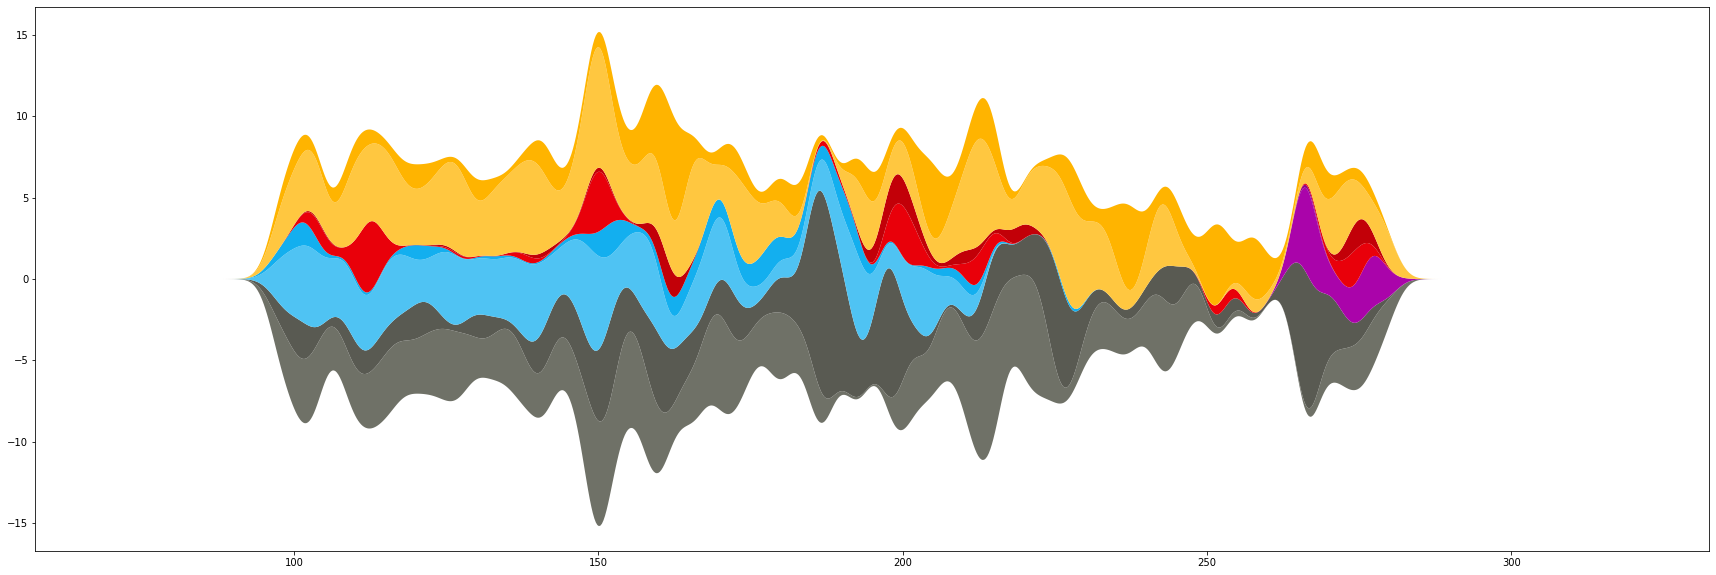

In [16]:
# Basic stacked area chart.
values_smoothed = [gaussian_smooth(x, y, grid, h=2) for x, y in zip(issues, values)]
# values_smoothed = [csaps(x, y, grid, smooth=0.05) for x, y in zip(issues, values)]
# yi = csaps(x, y, xi, smooth=0.8)
fig, ax = plt.subplots(figsize=(30, 10))
ax.stackplot(grid, values_smoothed[::-1], colors = pal[::-1], baseline='sym');

In [17]:
# x = issue
# y = value
# color = char_costume
# fill = char_costume